![alt text](/home/yt/datascience/The-circumplex.ppm.png "circumplex")

## Valence-Arousal Prediction Audio and Visual Features

The Mediaeval 2017 Emotional Impact of Movies Task includes the data in the emotional domain 
(valence - arousal  regression) and  fear ( binary classification).
We have displayed the valence and arousal of all the movies in the dataset.
Also the time of the movie where fear is present is specified with the value of the second.
According to the Russell's circumplex model we were expectinf the "FEAR" to be appeared in the negative vallence, positive arousal part of the circumflex.
However in some movies, we can see that frightment exists in positive valence with negative arousal also.


In [1]:

import pandas as pd
from pandas import DataFrame, Series

import matplotlib.pyplot as plt
import matplotlib.colors as colors


import matplotlib
matplotlib.style.use('ggplot')

%matplotlib inline

import numpy as np
import pylab as pl
import re, fileinput
import os.path
import glob
import pickle
import sys


In [2]:
import numpy as np 
print(np.__version__) 
print(np.__path__)


1.12.1
['/home/deepuser/anaconda3/lib/python3.6/site-packages/numpy']


In [3]:
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn import metrics
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn import svm
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
import scipy
from scipy.stats import pearsonr


In [4]:
med2017visualFeaturesfolder='/home/deepuser/yasemin/MEDIAEVAL17-DevSet-Visual_features/features/'
med2017audiofolder='/home/deepuser/yasemin/MEDIAEVAL17-DevSet-Audio_features/features/'
med2017annotationsFolder = '/home/deepuser/yasemin/MEDIAEVAL17-DevSet-Valence_Arousal-annotations/annotations/'
med2017fearFolder = '/home/deepuser/yasemin/MEDIAEVAL17-DevSet-Fear-annotations/annotations/'
med2017dataFolder='/home/deepuser/yasemin/continuous-movies/'

In [5]:
med2017visualfolderTest='/home/deepuser/yasemin/MEDIAEVAL17-TestSet-Visual_features/visual_features/'
med2017audiofolderTest = '/home/deepuser/yasemin/MEDIAEVAL17-TestSet-Audio_features/audio_features/'
med2017datafolderTest = '/home/deepuser/yasemin/MEDIAEVAL17-TestSet-Data/data/'


In [6]:
files = glob.glob(med2017datafolderTest+'*')
testmovieNames =[ f.split('/')[-1].replace('.mp4','') for f in sorted(files) ]

In [7]:
files = glob.glob(med2017dataFolder+'*')
movieNames =[ f.split('/')[-1].replace('.mp4','') for f in sorted(files) ]

In [8]:
movieNames,testmovieNames

(['After_The_Rain',
  'Attitude_Matters',
  'Barely_legal_stories',
  'Between_Viewings',
  'Big_Buck_Bunny',
  'Chatter',
  'Cloudland',
  'Damaged_Kung_Fu',
  'Decay',
  'Elephant_s_Dream',
  'First_Bite',
  'Full_Service',
  'Islands',
  'Lesson_Learned',
  'Norm',
  'Nuclear_Family',
  'On_time',
  'Origami',
  'Parafundit',
  'Payload',
  'Riding_The_Rails',
  'Sintel',
  'Spaceman',
  'Superhero',
  'Tears_of_Steel',
  'The_room_of_franz_kafka',
  'The_secret_number',
  'To_Claire_From_Sonny',
  'Wanted',
  'You_Again'],
 ['MEDIAEVAL17_00',
  'MEDIAEVAL17_01',
  'MEDIAEVAL17_02',
  'MEDIAEVAL17_03',
  'MEDIAEVAL17_04',
  'MEDIAEVAL17_05',
  'MEDIAEVAL17_06',
  'MEDIAEVAL17_07',
  'MEDIAEVAL17_08',
  'MEDIAEVAL17_09',
  'MEDIAEVAL17_10',
  'MEDIAEVAL17_11',
  'MEDIAEVAL17_12',
  'MEDIAEVAL17_13'])

In [9]:
movgroups_wodecay = {
    0:['You_Again','Damaged_Kung_Fu','The_secret_number','Spaceman'],
    1:['Cloudland','Origami','Riding_The_Rails','Tears_of_Steel','Sintel'],
    2:['On_time','Elephant_s_Dream','Norm','Big_Buck_Bunny','Chatter','Full_Service'],
    3:['Islands','To_Claire_From_Sonny','Nuclear_Family','After_The_Rain','Parafundit'],
    4:['The_room_of_franz_kafka','Attitude_Matters','Lesson_Learned','Superhero'],
    5:['First_Bite','Wanted','Between_Viewings','Barely_legal_stories','Payload']
}

movgroups = {
    0:['You_Again','Damaged_Kung_Fu','The_secret_number','Spaceman'],
    1:['Cloudland','Origami','Riding_The_Rails','Tears_of_Steel','Sintel'],
    2:['On_time','Elephant_s_Dream','Norm','Big_Buck_Bunny','Chatter','Full_Service'],
    3:['Islands','To_Claire_From_Sonny','Nuclear_Family','After_The_Rain','Parafundit'],
    4:['The_room_of_franz_kafka','Attitude_Matters','Lesson_Learned','Superhero'],
    5:['First_Bite','Wanted','Between_Viewings','Barely_legal_stories','Payload'],
    6:['Decay']
}

mov2groups = {
    0:['Decay'],
    1:['You_Again','Damaged_Kung_Fu','The_secret_number','Spaceman'],
    2:['Cloudland','Origami','Riding_The_Rails','Tears_of_Steel','Sintel'],
    3:['On_time','Elephant_s_Dream','Norm','Big_Buck_Bunny','Chatter','Full_Service'],
    4:['Islands','To_Claire_From_Sonny','Nuclear_Family','After_The_Rain','Parafundit'],
    5:['The_room_of_franz_kafka','Attitude_Matters','Lesson_Learned','Superhero'],
    6:['First_Bite','Wanted','Between_Viewings','Barely_legal_stories','Payload'],
}


def gettraintestmovielist(mlist,groups=movgroups):
    testlist = groups[mlist]
    trainlist =[]
    for idx, group in enumerate(groups):
        if idx != mlist:
            for g in groups[idx]:
                trainlist.append(g)
    return trainlist, testlist

def gettraintest2movielist(foldno,groups=mov2groups):
    if foldno==1:
        mlist=[1,2]
    elif foldno==2:
        mlist=[3,4]
    elif foldno==3:
        mlist=[5,6]
    elif foldno==4:
        mlist=[2,3]
    elif foldno==5:
        mlist=[4,5]
    else:
        mlist=[]
    
    testlist = [] 
    for i in mlist:
        for f in groups[i]:
            testlist.append(f)
            
    trainlist =[]
    for idx, group in enumerate(groups):
        for f in groups[idx]:
            if f not in testlist:
                trainlist.append(f)
                
    return trainlist, testlist

In [10]:
gettraintest2movielist(4)


(['Decay',
  'You_Again',
  'Damaged_Kung_Fu',
  'The_secret_number',
  'Spaceman',
  'Islands',
  'To_Claire_From_Sonny',
  'Nuclear_Family',
  'After_The_Rain',
  'Parafundit',
  'The_room_of_franz_kafka',
  'Attitude_Matters',
  'Lesson_Learned',
  'Superhero',
  'First_Bite',
  'Wanted',
  'Between_Viewings',
  'Barely_legal_stories',
  'Payload'],
 ['Cloudland',
  'Origami',
  'Riding_The_Rails',
  'Tears_of_Steel',
  'Sintel',
  'On_time',
  'Elephant_s_Dream',
  'Norm',
  'Big_Buck_Bunny',
  'Chatter',
  'Full_Service'])

## Valence - Arosal Annotations
Thank you for downloading LIRIS-ACCEDE dataset.
This file contains valence/arousal annotations for the LIRIS-ACCEDE continuous part that is used for the first subtask of the MEDIAEVAL 2017 Emotional Impact of Movies task.
For each of the 30 movies, consecutive ten seconds-segments sliding over the whole movie with a shift of 5 seconds are considered and provided with valence and arousal annotations.
Each txt file contains 4 columns separated by tabulations. The first column is the segment id, starting from 0, the second column is the starting time of the segment in the movie and the third and fourth columns are respectively the valence and arousal values for this segment.

In [11]:
def getAnnotationDf(movname,folder=med2017annotationsFolder):
    filename = os.path.join(folder, movname + '-MEDIAEVAL2017-valence_arousal.txt')
    annotation = np.genfromtxt(filename, names=True, delimiter='\t', dtype=None)
    df = pd.DataFrame(annotation)
    return df

In [12]:
df = getAnnotationDf(movieNames[0])
#df.hist(alpha=0.5,bins=50)

In [13]:
#df.head()
#df.describe()

## Valence, Arousal histogram plots for Dev-Set

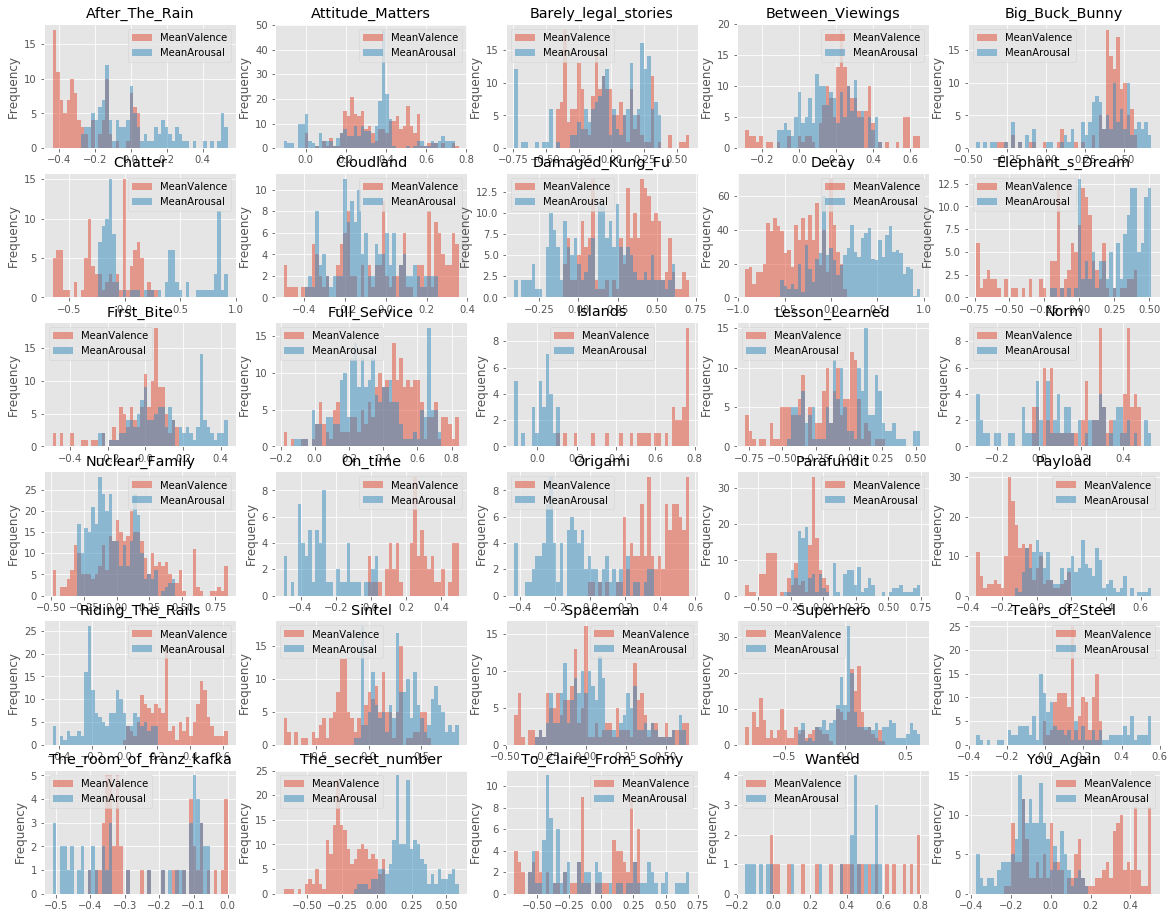

In [13]:
fix, axes = plt.subplots(figsize=(20,16))
for ii, mov in enumerate(movieNames):
    if (ii+1 > 30):
        plt.subplot(6,5,ii)
    else :
        plt.subplot(6,5,ii+1)
    df = getAnnotationDf(mov)
    df[['MeanValence','MeanArousal']].plot.hist(ax=plt.gca(),title=mov,alpha=0.5,bins=50)

## Valence , Arousal plots for Dev-Set

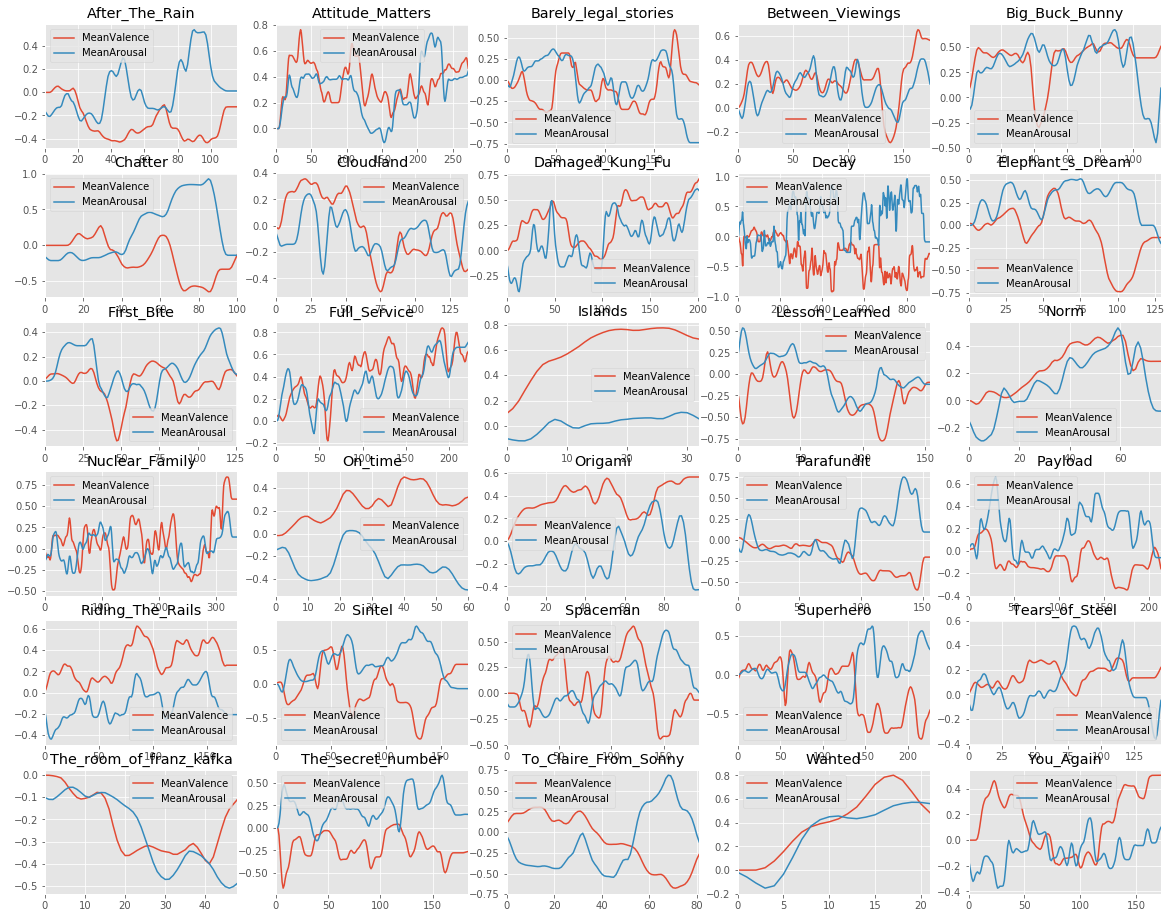

In [14]:
fix, axes = plt.subplots(figsize=(20,16))
for ii, mov in enumerate(movieNames):
    plt.subplot(6,5,ii+1)
    df = getAnnotationDf(mov)
    df[['MeanValence','MeanArousal']].plot(ax=plt.gca(),title=mov)
    #.hist(alpha=0.5,bins=50)


## Fear Annotations

In [15]:
def getFearDf(movname):
    filename = os.path.join(med2017fearFolder, movname + '-MEDIAEVAL2017-fear.txt')
    annotation = np.genfromtxt(filename, names=True, delimiter='\t', dtype=None)
    df = pd.DataFrame(annotation)
    return df


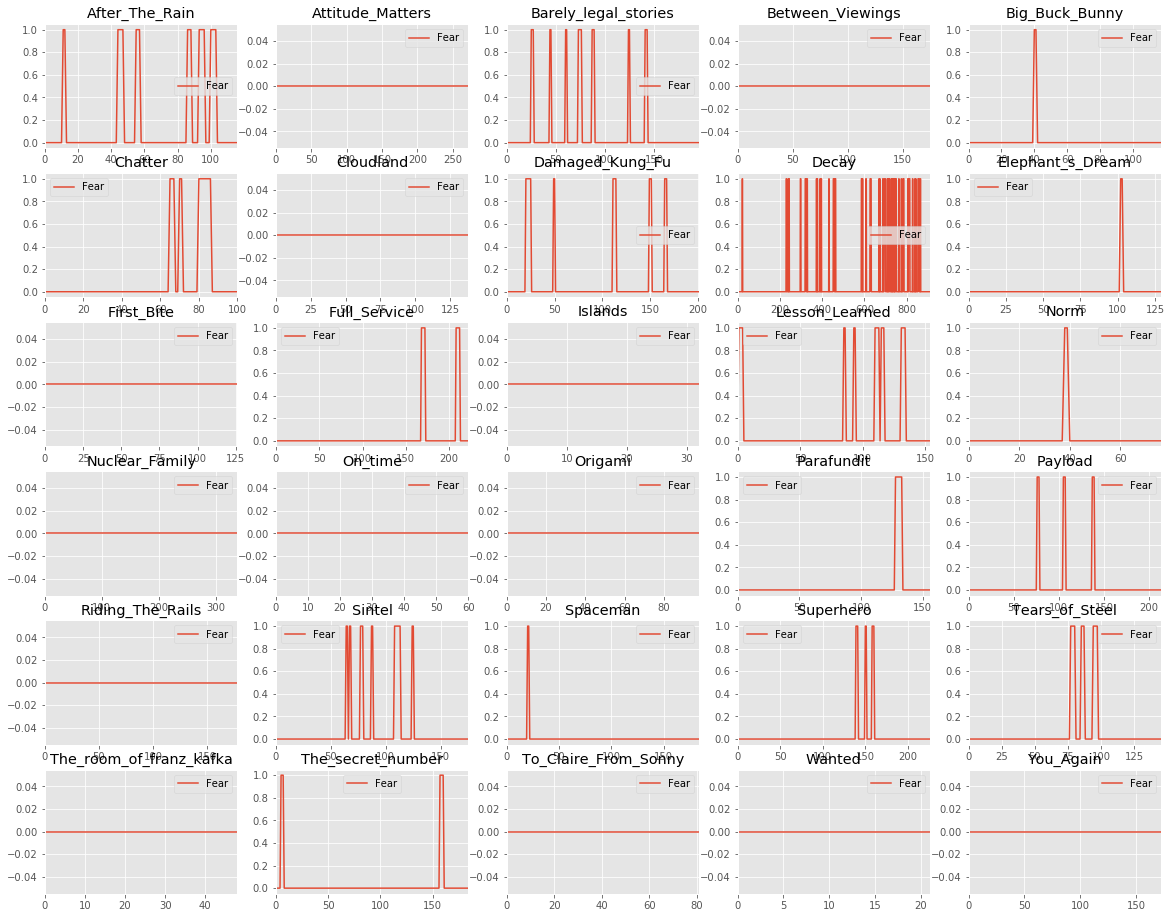

In [14]:
fix, axes = plt.subplots(figsize=(20,16))
for ii, mov in enumerate(movieNames):
    plt.subplot(6,5,ii+1)
    df = getFearDf(mov)
    df[['Fear']].plot(ax=plt.gca(),title=mov)

## Audio Features


In [16]:
def getAudioDf(moviename,folder=med2017audiofolder):
    if 'TestSet' in folder:
        files = glob.glob(folder+moviename+'/audio_features/*.csv')
    else:
        files = glob.glob(folder+moviename+'/*.csv')
    files = sorted(files)
    files
    alist = []
    for fname in files:
        f=open(fname,'r')
        h = []
        for l in f :
            if '@attribute' in l:
                h.append(l.split()[1])
            elif l == '\n':
                l
            elif l[0] =='@':
                l
            else:
                alist.append(map(float,l.split(',')[1:])) #first attribute is string ,skipped
        f.close()
    
    return pd.DataFrame(alist,columns=h[1:])

## Visual Features

In [17]:
visual_feat = ['acc', 'cedd', 'cl', 'eh', 'fc6', 'fcth', 
               'gabor', 'jcd', 'lbp', 'sc', 'tamura'   ]
visual_feat_wofc16 = ['acc', 'cedd', 'cl', 'eh', 'fcth', 
               'gabor', 'jcd', 'lbp', 'sc', 'tamura'   ]

In [18]:
def getVisFeatureDf(moviename,typename,folder=med2017visualFeaturesfolder):
    files = glob.glob(folder+moviename+'/'+typename+'/*.txt')
    files = sorted(files)
    alist = []
    for fname in files:
        f=open(fname,'r')
        for l in f:
            alist.append(map(float,l.split(',')))
        f.close()
    return pd.DataFrame(alist)

def getAvgVisFeatureDf(moviename,typename,folder=med2017visualFeaturesfolder):
    df = getVisFeatureDf(moviename,typename,folder)
    dfwindow = df.rolling(10).mean()[10::5]
    dfwindow.reset_index(inplace=True)
    dfwindow.drop('index',axis=1,inplace=True)
    return dfwindow

def getAvgVisFeatListDf(moviename,featlist,folder=med2017visualFeaturesfolder):
    df = getVisFeatureDf(moviename,featlist[0],folder)
    for feat in featlist[1:]:
        tdf = getVisFeatureDf(moviename,feat,folder)
        df = pd.concat([df,tdf],axis=1)
    
    dfwindow = df.rolling(10).mean()[10::5]
    dfwindow.reset_index(inplace=True)
    dfwindow.drop('index',axis=1,inplace=True)
    dfwindow.columns=list(range(len(dfwindow.columns)))
    return dfwindow

In [19]:
sum([len(getAnnotationDf(m)) for m in movieNames ])

5274

In [20]:
sum([len(getAudioDf(m)) for m in movieNames ])

5264

In [19]:
sum([len(getVisFeatureDf(m,'cl')) for m in movieNames ])

26589

In [20]:
sum([len(getAvgVisFeatureDf(m,'cl')) for m in movieNames ])

5271

In [ ]:
df = getVisFeatureDf(movieNames[0],'cl')
df = getAvgVisFeatureDf(movieNames[0],'cl')
df = getAvgVisFeatListDf(movieNames[0],['cl','eh'])
#df.hist()

In [96]:
df = getAvgVisFeatListDf(movieNames[0],['fc6'])
df = getVisFeatureDf(movieNames[0],'fc6')
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
count,591.000000,591.000000,591.000000,591.000000,591.000000,591.000000,591.000000,591.000000,591.000000,591.000000,...,591.000000,591.000000,591.000000,591.000000,591.000000,591.000000,591.000000,591.000000,591.000000,591.000000
mean,-6.034982,-1.370833,-7.608151,-10.225488,-11.605717,-5.210584,-0.570106,-0.399201,-4.358834,-1.530431,...,-6.772922,-3.920235,3.535808,-3.768895,-0.972970,-1.450922,-4.061289,-8.889291,-2.828903,-2.474411
std,5.282046,6.120563,6.696587,7.882340,8.416353,6.397838,7.603316,6.955639,6.411402,6.803205,...,8.787879,7.053448,5.910079,6.382576,5.995845,6.195906,6.565671,9.470718,5.747899,7.482110
min,-27.093000,-33.372000,-37.525000,-36.351000,-40.676000,-26.772000,-25.291000,-25.200000,-28.966000,-30.389000,...,-34.824000,-27.532000,-16.982000,-29.007000,-22.957000,-24.226000,-39.624000,-34.192000,-23.258000,-21.932000
25%,-9.277450,-4.514200,-10.872000,-16.686000,-18.211000,-9.816700,-5.612200,-3.276300,-8.852800,-5.778500,...,-13.373000,-8.350050,0.881240,-7.429650,-4.059700,-4.716550,-7.310950,-16.588000,-6.307700,-6.938300
50%,-4.939700,-0.019979,-6.017600,-9.100000,-11.602000,-4.925500,1.125800,-0.814240,-3.064100,-0.099341,...,-5.215600,-2.846400,2.869400,-2.307000,-0.345480,0.210580,-2.251800,-9.553300,-1.961800,-1.058600
75%,-2.666800,2.603200,-3.512900,-5.564500,-4.544150,0.673480,4.469550,3.152650,1.091150,2.669500,...,0.645515,-0.309410,7.675050,0.405880,2.920500,2.043250,-0.061775,0.257495,0.989700,3.095550
max,8.583500,20.884000,14.416000,11.816000,11.996000,10.658000,15.773000,20.884000,10.014000,19.303000,...,13.877000,19.664000,18.261000,11.987000,22.251000,14.256000,13.800000,10.841000,16.857000,17.493000


## Train and Test set creation

In [21]:
def getFeatureswAnnotationsDf(movieNames,featlist=visual_feat_wofc16):
    Xv = getAvgVisFeatListDf(movieNames[0],featlist)
    Xa = getAudioDf(movieNames[0])
    Xd = getAvgVisFeatListDf(movieNames[0],['fc6'])
    y = getAnnotationDf(movieNames[0])[['MeanValence','MeanArousal']]
    
    mlen = min(len(Xv),len(Xa), len(Xd),len(y))
    
    Xv = Xv[:mlen]
    Xa = Xa[:mlen]
    Xd = Xd[:mlen]
    y = y[:mlen]
    
    for mov in movieNames[1:]:
        tXv = getAvgVisFeatListDf(mov,featlist)
        tXa = getAudioDf(mov)
        tXd = getAvgVisFeatListDf(mov,['fc6'])
        ty = getAnnotationDf(mov)[['MeanValence','MeanArousal']]
        
        mlen = min(len(tXv),len(tXa),len(tXd),len(ty))
        tXv = tXv[:mlen]
        tXa = tXa[:mlen]
        tXd = tXd[:mlen]
        ty = ty[:mlen]
        
        Xv  = Xv.append(tXv)
        Xa  = Xa.append(tXa)
        Xd = Xd.append(tXd)
        y  = y.append(ty)
        
    return Xv,Xa,Xd,y

In [22]:
def getMovListAudioVisFeatListwAnnotationsDf(movieNames,featlist):
    Xv = getAvgVisFeatureDf(movieNames[0],featlist[0])
    Xa = getAudioDf(movieNames[0])
    y = getAnnotationDf(movieNames[0])[['MeanValence','MeanArousal']]
    
    mlen = min(len(Xv),len(Xa),len(y))
    print(mlen)
    
    Xv = Xv[:mlen]
    Xa = Xa[:mlen]
    y = y[:mlen]
    
    for feattype in featlist[1:]:
        fXv = getAvgVisFeatureDf(movieNames[0],feattype)[:mlen]
        Xv = pd.concat( [Xv,fXv], axis=1 )

    for mov in movieNames[1:]:
        tXv = getAvgVisFeatureDf(mov,featlist[0])
        tXa = getAudioDf(mov)
        ty = getAnnotationDf(mov)[['MeanValence','MeanArousal']]
        
        mlen = min(len(tXv),len(tXa),len(ty))
        print(mlen)
        
        tXv = tXv[:mlen]
        tXa = tXa[:mlen]
        ty = ty[:mlen]
        
        for feattype in featlist[1:]:
            fXv = getAvgVisFeatureDf(mov,feattype)[:mlen]
            tXv = pd.concat( [tXv,fXv], axis=1 )
        
        Xv  = Xv.append(tXv)
        Xa  = Xa.append(tXa)
        y  = y.append(ty)
        
    return Xv,Xa,y

In [23]:
def df2mat(df):
    return df.as_matrix().reshape((len(df),))


In [24]:
%%time
allXv,allXa,allXd,ally = getFeatureswAnnotationsDf(movieNames)
print(allXv.shape,allXa.shape,allXd.shape,ally.shape)

(5264, 1271) (5264, 1583) (5264, 4096) (5264, 2)
CPU times: user 2min 9s, sys: 3.33 s, total: 2min 12s
Wall time: 2min 12s


In [25]:
trainlist, testlist=gettraintest2movielist(2)  # index 1 olanları test , diğerlerini train yapan fonksiyon

tXv,tXa,tXd,ty = getFeatureswAnnotationsDf(trainlist)
print(tXv.shape,tXa.shape,tXd.shape,ty.shape)
testXv, testXa, testXd, testy = getFeatureswAnnotationsDf(testlist)
print(testXv.shape, testXa.shape,testXd.shape, testy.shape)

X_train, X_test, y_train, y_test = train_test_split(tXv, ty,test_size=0.2, random_state=0)
Xa_train, Xa_test, ya_train, ya_test = train_test_split(tXa, ty,test_size=0.2, random_state=0)
Xd_train, Xd_test, yd_train, yd_test = train_test_split(tXd, ty,test_size=0.2, random_state=0)


(4556, 1271) (4556, 1583) (4556, 4096) (4556, 2)
(708, 1271) (708, 1583) (708, 4096) (708, 2)


## Grid Search on Visual Features- Valence

In [31]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.grid_search import GridSearchCV 
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


def getGridCV(pipe,paramgirid,Xtrain,ytrain): # scoring ?
    grid = GridSearchCV(pipe, param_grid, cv=5,n_jobs=125)
    grid.fit(Xtrain,ytrain)
    
    return grid

    

/home/deepuser/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/deepuser/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [33]:
%%time

#X_train, X_test, y_train, y_test 
#pipe = Pipeline([('preprocessing', StandardScaler()),('reduce_dim', PCA()) ,('classifier', SVR())])
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVR())])

param_grid = [
    {'classifier': [SVR()], 
     'preprocessing': [StandardScaler()],
#     'reduce_dim': [PCA()],
#     'reduce_dim__n_components' : [ 800],
     'classifier__gamma': [0.0001, 0.001,0.01, 0.1, 1, 10, 100],
     'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100,200]},
    {'classifier': [RandomForestRegressor(n_estimators=100)],
     'preprocessing': [None], 'classifier__max_features': [3,5,10]}]

grid_vis_valence = getGridCV(pipe,param_grid,X_train,df2mat(y_train[['MeanValence']]))

print("Best params:\n{}\n".format(grid_vis_valence.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_vis_valence.best_score_))
print("All grid scores")

grid_vis_valence.grid_scores_, grid_vis_valence.best_params_, grid_vis_valence.best_score_

Best params:
{'classifier': SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.001,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False), 'classifier__C': 10, 'classifier__gamma': 0.001, 'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True)}

Best cross-validation score: 0.80
All grid scores
CPU times: user 1min 40s, sys: 7.99 s, total: 1min 48s
Wall time: 2min 36s


In [35]:
tXv.shape,tXa.shape,ty.shape,
testXv.shape, testXa.shape, testy.shape

((708, 1271), (708, 1583), (708, 2))

In [34]:
#scores[0]
#scores.to_csv('grid_vis_valence.txt')

In [25]:
def gridscores(grid):
    scores = grid.grid_scores_
    rows = []
    params = sorted(scores[0].parameters)
    for row in scores:
        mean = row.mean_validation_score
        std = row.cv_validation_scores.std()
        rows.append([mean, std] + [row.parameters['classifier']])
    scores = pd.DataFrame(rows, columns=['mean_', 'std_'] + ['classifier'])
    #scores.to_csv(filename)
    return scores

In [38]:
gridscores(grid_vis_valence).head()

,mean_,std_,classifier
0,0.027756,0.002676,"SVR(C=0.001, cache_size=200, coef0=0.0, degree..."
1,0.090598,0.006459,"SVR(C=0.001, cache_size=200, coef0=0.0, degree..."
2,0.007033,0.002441,"SVR(C=0.001, cache_size=200, coef0=0.0, degree..."
3,-0.001896,0.002285,"SVR(C=0.001, cache_size=200, coef0=0.0, degree..."
4,-0.002034,0.002289,"SVR(C=0.001, cache_size=200, coef0=0.0, degree..."


In [25]:
from sklearn import metrics
from scipy.stats import pearsonr

def getMetrics(y,y_pred):
    # calculate MAE using scikit-learn
    #mae = metrics.mean_absolute_error(ytestarray, y_pred)
    #print("MAE score: {:.5f}".format(mae))
    
    mse = metrics.mean_squared_error(y, y_pred)
    # calculate MSE using scikit-learn
    print("MSE score: {:.5f}".format(mse))

    # calculate RMSE using scikit-learn
    #print("RMSE: {:.5f}".format(np.sqrt(metrics.mean_squared_error(ytestarray, y_pred))))

    print("Pearson score:")
    prs = pearsonr(y,y_pred)
    print(prs)
    
    return mse,prs

In [26]:
def evaluate_pipe(pipe,trainX,trainy,testX,testy):
    
    ytrainarray = trainy.as_matrix().reshape((len(trainy),))
    ytestarray = testy.as_matrix().reshape((len(testy),))

    pipe.fit(trainX, ytrainarray)
    
    print("Train score: {:.2f}".format(pipe.score(trainX, ytrainarray)))
    print("Test score: {:.2f}".format(pipe.score(testX, ytestarray)))

    y_pred = pipe.predict(testX)

    mse, prs = getMetrics(ytestarray,y_pred)
    
    return y_pred,mse,prs[0],pipe

In [27]:
from joblib import Parallel, delayed

import multiprocessing
# what are your inputs, and what operation do you want to
# perform on each input. For example...

def trainPipe(ii,pipe,valorar, modality):
    
    #rows = []
    trainlist, testlist=gettraintest2movielist(ii,mov2groups)  # index 1 olanları test , diğerlerini train yapan fonksiyon
    tXv,tXa,tXd,ty = getFeatureswAnnotationsDf(trainlist)
    print(tXv.shape,tXa.shape,tXd.shape,ty.shape)
    testXv, testXa, testXd, testy = getFeatureswAnnotationsDf(testlist)
    print(testXv.shape, testXa.shape,testXd.shape, testy.shape)

    if modality == 'visual':
        y_pred_test,mse,prs,p1 = evaluate_pipe(pipe, 
                                           tXv,ty[[valorar]], 
                                           testXv, testy[[valorar]])
    else:
        y_pred_test,mse,prs,p1 = evaluate_pipe(pipe, 
                                           tXa,ty[[valorar]], 
                                           testXa, testy[[valorar]])
        
    return ii,mse,prs,p1

def processGroup(ii,pipe,valorar, modality):
    
    #rows = []
    trainlist, testlist=gettraintest2movielist(ii,mov2groups)  # index 1 olanları test , diğerlerini train yapan fonksiyon
    tXv,tXa,tXd,ty = getFeatureswAnnotationsDf(trainlist)
    print(tXv.shape,tXa.shape,tXd.shape,ty.shape)
    testXv, testXa, testXd, testy = getFeatureswAnnotationsDf(testlist)
    print(testXv.shape, testXa.shape,testXd.shape, testy.shape)

    if modality == 'visual':
        y_pred_test,mse,prs,p1 = evaluate_pipe(pipe, 
                                           tXv,ty[[valorar]], 
                                           testXv, testy[[valorar]])
    else:
        y_pred_test,mse,prs,p1 = evaluate_pipe(pipe, 
                                           tXa,ty[[valorar]], 
                                           testXa, testy[[valorar]])
        
    return [ii,mse,prs]

def crossgroups(pipe,valorar,modality):
    #inputs=range(len(movgroups))
    inputs=[1, 2, 3, 4, 5]
    num_cores = multiprocessing.cpu_count()
    results = Parallel(n_jobs=num_cores)(delayed(processGroup)(i,pipe,valorar,modality) for i in inputs)
    pipescores = pd.DataFrame(results,columns=['test-group','MSE','PCC'])

    return pipescores


In [59]:
ii1,mse1,prs1,pva = trainPipe(4,pipe_visual_valence,'MeanValence','visual')
ii2,mse2,prs2,pvv = trainPipe(3,pipe_audio_valence,'MeanValence','audio')



(3818, 1271) (3818, 1583) (3818, 4096) (3818, 2)
(1446, 1271) (1446, 1583) (1446, 4096) (1446, 2)
Train score: 0.95
Test score: -0.73
MSE score: 0.15579
Pearson score:
(0.39415670149140347, 6.0520934336701606e-55)
(3827, 1271) (3827, 1583) (3827, 4096) (3827, 2)
(1437, 1271) (1437, 1583) (1437, 4096) (1437, 2)
Train score: 0.94
Test score: -0.03
MSE score: 0.09450
Pearson score:
(0.25340858644380443, 1.7133760887453711e-22)


In [60]:
ii3,mse3,prs3,pav = trainPipe(1,pipe_visual_arousal,'MeanArousal','visual')
ii4,mse4,prs4,paa = trainPipe(1,pipe_audio_arousal,'MeanArousal','audio')


(3783, 1271) (3783, 1583) (3783, 4096) (3783, 2)
(1481, 1271) (1481, 1583) (1481, 4096) (1481, 2)
Train score: 0.93
Test score: -0.35
MSE score: 0.08112
Pearson score:
(0.14151114465619502, 4.530283935226392e-08)
(3783, 1271) (3783, 1583) (3783, 4096) (3783, 2)
(1481, 1271) (1481, 1583) (1481, 4096) (1481, 2)
Train score: 0.91
Test score: 0.04
MSE score: 0.05775
Pearson score:
(0.37670638887075969, 3.8682936818061836e-51)


## Generating N-fold csv

In [29]:
visual_feat_list= ['acc', 'cedd', 'cl', 'eh', 'fcth', 
               'gabor', 'jcd', 'lbp', 'sc', 'tamura'   ]

In [42]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(Xa_train.shape, Xa_test.shape, ya_train.shape, ya_test.shape)
print(tXv.shape,tXa.shape,ty.shape)
print(testXv.shape, testXa.shape, testy.shape)

(3644, 1271) (912, 1271) (3644, 2) (912, 2)
(3644, 1583) (912, 1583) (3644, 2) (912, 2)
(4556, 1271) (4556, 1583) (4556, 2)
(708, 1271) (708, 1583) (708, 2)


In [43]:
%%time
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

#X_train.shape, X_test.shape, y_train.shape, y_test.shape 
#tXv.shape,tXa.shape,ty.shape
#testXv.shape, testXa.shape, testy.shape

pipe_visual_valence = make_pipeline(
    StandardScaler(), 
    SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, 
        gamma=0.001, kernel='rbf', max_iter=-1, shrinking=True, 
        tol=0.001, verbose=False))

#SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.001,
#  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
# SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.001,
#  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

#X_train, X_test, y_train, y_test 
#y_pred_visV_train,mse,prs,pipe_vv = evaluate_pipe(pipe_visual_valence, 
#                                   X_train,y_train[['MeanValence']], 
#                                   X_test,  y_test[['MeanValence']])
#y_pred_vis,mse,prs = evaluate_pipe(pipe_visual_valence,tXv,ytrain,testXv,ytest)

#y_pred_visV_test,mse,prs,pipe_vv = evaluate_pipe(pipe_visual_valence, 
#                                   tXv,ty[['MeanValence']], 
#                                   testXv, testy[['MeanValence']])



Train score: 0.94
Test score: 0.81
MSE score: 0.02165
Pearson score:
(0.90344469546466666, 0.0)
Train score: 0.95
Test score: -0.79
MSE score: 0.19260
Pearson score:
(0.36441773046669984, 1.1692814368608515e-23)
CPU times: user 1min 9s, sys: 4 ms, total: 1min 9s
Wall time: 1min 9s


In [ ]:
#pipe_visual_valence_scores

In [ ]:
#sorted(pipe_visual_valence_scores.MSE),sorted(pipe_visual_valence_scores.PCC)

## Grid-Search on Audio features - Valence

In [48]:
%%time
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.grid_search import GridSearchCV 

#pipe = Pipeline([('preprocessing', StandardScaler()),('reduce_dim', PCA(n_components=600)) ,('classifier', SVR())])
pipe = Pipeline([('preprocessing', StandardScaler()),('classifier', SVR())])

param_grid = [
    {'classifier': [SVR()], 
     'preprocessing': [StandardScaler()],
     #'reduce_dim__n_components' : [ 50, 100, 500 ,750],
     'classifier__gamma': [0.001,0.01, 0.1, 1, 10, 100],
     'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]},
    {'classifier': [RandomForestRegressor()],
     'preprocessing': [None],
     'classifier__n_estimators': [100,400],
     'classifier__max_features': [3,5,10]}
]

grid_audio_valence = GridSearchCV(pipe, param_grid, cv=5,n_jobs=-1)
ytrainarray = ya_train[['MeanValence']].as_matrix()
ytrainarray = ytrainarray.reshape((len(ya_train),))
grid_audio_valence.fit(Xa_train,ytrainarray)

print("Best params:\n{}\n".format(grid_audio_valence.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_audio_valence.best_score_))
print("All grid scores")

grid_audio_valence.grid_scores_, grid_audio_valence.best_params_, grid_audio_valence.best_score_

Best params:
{'classifier': SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.001,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False), 'classifier__C': 100, 'classifier__gamma': 0.001, 'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True)}

Best cross-validation score: 0.53
All grid scores
CPU times: user 1min 44s, sys: 11.5 s, total: 1min 55s
Wall time: 2min 45s


In [63]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(Xa_train.shape, Xa_test.shape, ya_train.shape, ya_test.shape)
print(tXv.shape,tXa.shape,ty.shape)
print(testXv.shape, testXa.shape, testy.shape)

(2477, 1271) (1167, 1271) (2477, 2) (1167, 2)
(2915, 1583) (729, 1583) (2915, 2) (729, 2)
(3644, 1271) (3644, 1583) (3644, 2)
(708, 1271) (708, 1583) (708, 2)


In [49]:
%%time
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipe_audio_valence = make_pipeline(
    StandardScaler(copy=True, with_mean=True, with_std=True),
    SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.001,
        kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
)

#    SVR(C=10, cache_size=200, coef0=0.0, degree=3, 
#       epsilon=0.1, gamma=0.001,
#      kernel='rbf', max_iter=-1, 
#     shrinking=True, tol=0.001, verbose=False)


#Xa_train, Xa_test, ya_train, ya_test 
y_pred_audV_train,mse,prs,pipe_va = evaluate_pipe(pipe_audio_valence, 
                                   Xa_train,ya_train[['MeanValence']], 
                                   Xa_test,ya_test[['MeanValence']])

y_pred_audV_test,mse,prs,pipe_va = evaluate_pipe(pipe_audio_valence, 
                                   tXa,ty[['MeanValence']], 
                                   testXa,testy[['MeanValence']])



Train score: 0.93
Test score: 0.56
MSE score: 0.05061
Pearson score:
(0.76498279389571466, 4.5245244239857375e-176)
Train score: 0.93
Test score: -0.19
MSE score: 0.12872
Pearson score:
(0.22000713384401305, 3.2925748548172267e-09)
CPU times: user 2min 9s, sys: 24 ms, total: 2min 9s
Wall time: 2min 9s


In [68]:
pipe2scores = crossgroups(pipe_audio_valence,'MeanValence','audio')

(4352, 1271) (4352, 1583) (4352, 4096) (4352, 2)
(4526, 1271) (4526, 1583) (4526, 4096) (4526, 2)
(4529, 1271) (4529, 1583) (4529, 4096) (4529, 2)
(4556, 1271) (4556, 1583) (4556, 4096) (4556, 2)
(4538, 1271) (4538, 1583) (4538, 4096) (4538, 2)
(4521, 1271) (4521, 1583) (4521, 4096) (4521, 2)
(4562, 1271) (4562, 1583) (4562, 4096) (4562, 2)
(912, 1271) (912, 1583) (912, 4096) (912, 2)
(702, 1271) (702, 1583) (702, 4096) (702, 2)
(738, 1271) (738, 1583) (738, 4096) (738, 2)
(735, 1271) (735, 1583) (735, 4096) (735, 2)
(708, 1271) (708, 1583) (708, 4096) (708, 2)
(743, 1271) (743, 1583) (743, 4096) (743, 2)
(726, 1271) (726, 1583) (726, 4096) (726, 2)
Train score: 0.92
Train score: 0.94
Train score: 0.94
Train score: 0.93
Train score: 0.94
Test score: -1.85
Train score: 0.93
Train score: 0.94
Test score: -0.52
Test score: -0.19
Test score: -0.19
Test score: 0.08
Test score: 0.06
Test score: -0.09
MSE score: 0.21949
Pearson score:
(0.22803118653596122, 3.1928865845418501e-12)
MSE score: 0

In [69]:
pipe2scores


,test-group,MSE,PCC
0,0,0.078894,0.323093
1,1,0.107623,0.066597
2,2,0.128717,0.220007
3,3,0.121412,0.045289
4,4,0.124347,0.356526
5,5,0.059194,0.241319
6,6,0.219488,0.228031


In [70]:
pipe1scores

,test-group,MSE,PCC
0,0,0.135345,-0.088656
1,1,0.103613,0.296140
2,2,0.192597,0.364418
3,3,0.148517,0.006236
4,4,0.167325,-0.121752
5,5,0.078887,0.134925
6,6,0.207572,0.355358


In [149]:
y_pred_visV_train.shape,y_test.shape, y_pred_visV_test.shape,testy.shape

((1453,), (1453, 2), (726,), (726, 2))

In [151]:
y_pred_audV_train.shape,ya_test.shape, y_pred_audV_test.shape,testy.shape

((908,), (908, 2), (726,), (726, 2))

In [ ]:
y_val_vitrain = pipe_visual_valence.fit(tXv,df2mat(ty[['MeanValence']])).predict(tXv)
y_val_autrain = pipe_audio_valence.fit(tXa,df2mat(ty[['MeanValence']])).predict(tXa)

train_val = np.transpose([y_val_vitrain,y_val_autrain])
train_val_y = df2mat(ty[['MeanValence']])

pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVR())])

param_grid = [
    {'classifier': [SVR()],
     'classifier__kernel':['linear','rbf'],
     'preprocessing': [StandardScaler()],
     'classifier__gamma': [0.001,0.01, 0.1, 1, 10, 100],
     'classifier__C': [ 1, 10, 100]}
]

grid_valence_fuse = GridSearchCV(pipe, param_grid, cv=5,n_jobs=100)
grid_valence_fuse.fit(train_val,train_val_y)

print("Best params:\n{}\n".format(grid_valence_fuse.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_valence_fuse.best_score_))
print("All grid scores")


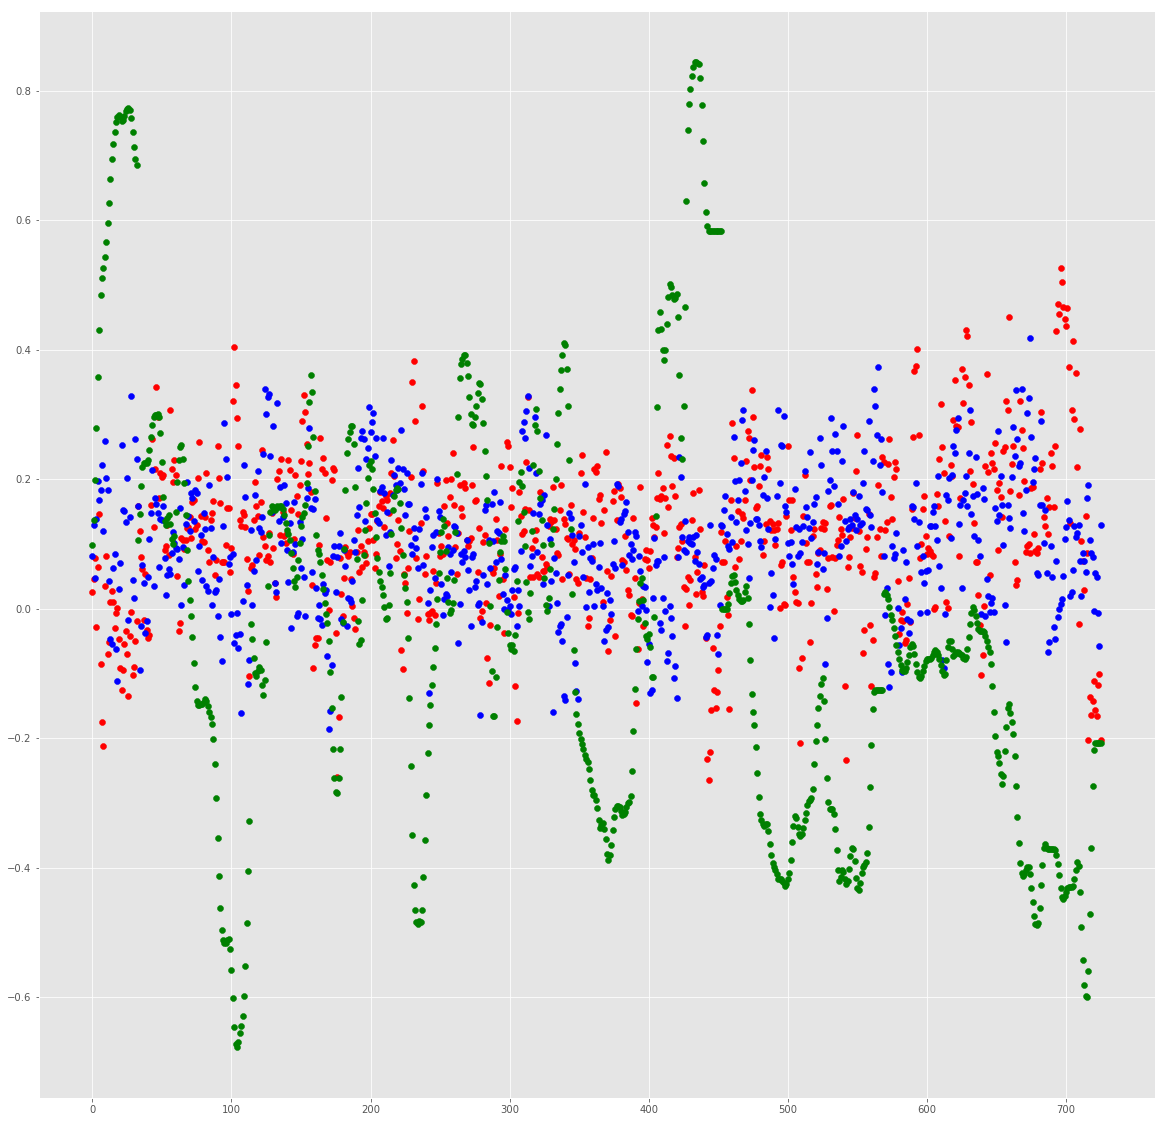

In [142]:
plt.figure(figsize=(20,20))
plt.scatter(range(len(testy)),y_pred_vis,c='r')
plt.scatter(range(len(testy)),y_pred_aud,c='b')
plt.scatter(range(len(testy)),df2mat(testy[['MeanValence']]),c='g')


## Grid Search on Visual Features -Arousal

In [ ]:
%%time
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVR())])

param_grid = [
    {'classifier': [SVR()], 'preprocessing': [StandardScaler()],
     'classifier__gamma': [0.001,0.01, 0.1, 1, 10, 100],
     'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]},
    {'classifier': [RandomForestRegressor()],
     'preprocessing': [None],
     'classifier__n_estimators': [100,400, 600, 1000],
     'classifier__max_features': [3,5,10,15,20]}
]

grid_vis_arousal = GridSearchCV(pipe, param_grid, cv=5,n_jobs=120)
ytrainarray = y_train[['MeanArousal']].as_matrix()
ytrainarray = ytrainarray.reshape((len(y_train),))
grid_vis_arousal.fit(X_train,ytrainarray)



In [72]:
print("Best params:\n{}\n".format(grid_vis_arousal.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_vis_arousal.best_score_))
grid_vis_arousal.grid_scores_, grid_vis_arousal.best_params_, grid_vis_arousal.best_score_

Best params:
{'classifier': SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.001,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False), 'classifier__C': 100, 'classifier__gamma': 0.001, 'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True)}

Best cross-validation score: 0.74


([mean: 0.06156, std: 0.00958, params: {'classifier': SVR(C=0.001, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.001,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False), 'classifier__C': 0.001, 'classifier__gamma': 0.001, 'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True)},
  mean: -0.00101, std: 0.00637, params: {'classifier': SVR(C=0.001, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False), 'classifier__C': 0.001, 'classifier__gamma': 0.01, 'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True)},
  mean: -0.00935, std: 0.00589, params: {'classifier': SVR(C=0.001, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False), 'classifier__C': 0.001, 'classifier__gamma': 0.1, 'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True)},
  mean: -0.009

In [73]:
grid_vis_arousal.best_params_

{'classifier': SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.001,
   kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
 'classifier__C': 100,
 'classifier__gamma': 0.001,
 'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True)}

In [74]:
grid_vis_arousal.best_score_

0.7385727011014819

In [75]:
%%time
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

#X_train.shape, X_test.shape, y_train.shape, y_test.shape 
#tXv.shape,tXa.shape,ty.shape
#testXv.shape, testXa.shape, testy.shape

pipe_visual_arousal = make_pipeline(
    StandardScaler(), 
    SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, 
        gamma=0.001, kernel='rbf', max_iter=-1, shrinking=True, 
        tol=0.001, verbose=False))

#X_train, X_test, y_train, y_test 
y_pred_visA_train,mse,prs,pipe_av = evaluate_pipe(pipe_visual_arousal, 
                                   X_train,y_train[['MeanArousal']], 
                                   X_test,  y_test[['MeanArousal']])

y_pred_visA_test,mse,prs,pipe_av = evaluate_pipe(pipe_visual_arousal, 
                                   tXv,ty[['MeanArousal']], 
                                   testXv, testy[['MeanArousal']])


Train score: 0.92
Test score: 0.78
MSE score: 0.01907
Pearson score:
(0.88831506127409721, 8.414561858120353e-310)
Train score: 0.92
Test score: -0.28
MSE score: 0.11210
Pearson score:
(0.11492042888053544, 0.0021943582863590029)
CPU times: user 1min 8s, sys: 48 ms, total: 1min 8s
Wall time: 1min 8s


In [148]:
y_pred_visA_train.shape,y_test.shape, y_pred_visA_test.shape,testy.shape

((1453,), (1453, 2), (726,), (726, 2))

In [76]:
pipe3scores = crossgroups(pipe_visual_arousal,'MeanArousal','visual')

(4352, 1271) (4352, 1583) (4352, 4096) (4352, 2)
(4526, 1271) (4526, 1583) (4526, 4096) (4526, 2)
(4529, 1271) (4529, 1583) (4529, 4096) (4529, 2)
(4521, 1271) (4521, 1583) (4521, 4096) (4521, 2)
(4538, 1271) (4538, 1583) (4538, 4096) (4538, 2)
(4556, 1271) (4556, 1583) (4556, 4096) (4556, 2)
(4562, 1271) (4562, 1583) (4562, 4096) (4562, 2)
(743, 1271) (743, 1583) (743, 4096) (743, 2)
(702, 1271) (702, 1583) (702, 4096) (702, 2)
(912, 1271) (912, 1583) (912, 4096) (912, 2)
(738, 1271) (738, 1583) (738, 4096) (738, 2)
(735, 1271) (735, 1583) (735, 4096) (735, 2)
(726, 1271) (726, 1583) (726, 4096) (726, 2)
(708, 1271) (708, 1583) (708, 4096) (708, 2)
Train score: 0.91
Train score: 0.93
Train score: 0.93
Test score: 0.10
Train score: 0.93
Train score: 0.93
Train score: 0.92
Train score: 0.93
Test score: -0.53
Test score: -0.23
MSE score: 0.11514
Pearson score:
(0.37904846653261204, 1.551505325235092e-32)
Test score: -0.20
Test score: -0.12
Test score: -0.28
MSE score: 0.08356
Pearson sco

In [77]:
pipe3scores

,test-group,MSE,PCC
0,0,0.053787,0.224167
1,1,0.087400,0.275252
2,2,0.112104,0.114920
3,3,0.083560,0.001598
4,4,0.079956,0.073692
5,5,0.058802,0.189082
6,6,0.115136,0.379048


## Grid Search on Audio Features -Arousal

In [78]:
%%time
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVR())])

param_grid = [
    {'classifier': [SVR()], 'preprocessing': [StandardScaler()],
     'classifier__gamma': [0.001,0.01, 0.1, 1, 10, 100],
     'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]},
    {'classifier': [RandomForestRegressor()],
     'preprocessing': [None],
     'classifier__n_estimators': [100,400, 600, 1000],
     'classifier__max_features': [3,5,10,15,20]}
]

grid_audio_arousal = GridSearchCV(pipe, param_grid, cv=5,n_jobs=220)
ytrainarray = ya_train[['MeanArousal']].as_matrix()
ytrainarray = ytrainarray.reshape((len(ya_train),))
grid_audio_arousal.fit(Xa_train,ytrainarray)



CPU times: user 2min 37s, sys: 26.6 s, total: 3min 3s
Wall time: 4min 2s


In [79]:
print("Best params:\n{}\n".format(grid_audio_arousal.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_audio_arousal.best_score_))
grid_audio_arousal.grid_scores_, grid_audio_arousal.best_params_, grid_audio_arousal.best_score_

Best params:
{'classifier': SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.001,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False), 'classifier__C': 100, 'classifier__gamma': 0.001, 'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True)}

Best cross-validation score: 0.46


([mean: 0.01696, std: 0.00651, params: {'classifier': SVR(C=0.001, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.001,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False), 'classifier__C': 0.001, 'classifier__gamma': 0.001, 'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True)},
  mean: -0.00948, std: 0.00590, params: {'classifier': SVR(C=0.001, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False), 'classifier__C': 0.001, 'classifier__gamma': 0.01, 'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True)},
  mean: -0.00949, std: 0.00590, params: {'classifier': SVR(C=0.001, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False), 'classifier__C': 0.001, 'classifier__gamma': 0.1, 'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True)},
  mean: -0.009

In [80]:
grid_audio_arousal.best_score_

0.45895912404912326

In [148]:
X_train.columns

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1261, 1262, 1263, 1264, 1265, 1266, 1267, 1268, 1269, 1270],
           dtype='int64', length=1271)

In [81]:
%%time
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipe_audio_arousal = make_pipeline(
    StandardScaler(copy=True, with_mean=True, with_std=True),  
    SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.001,
        kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
)
y_pred_audA_train,mse,prs,pipe_aa = evaluate_pipe(pipe_audio_arousal, 
                                   Xa_train,ya_train[['MeanArousal']], 
                                   Xa_test,ya_test[['MeanArousal']])

y_pred_audA_test,mse,prs,pipe_aa = evaluate_pipe(pipe_audio_arousal, 
                                   tXa,ty[['MeanArousal']], 
                                   testXa,testy[['MeanArousal']])



Train score: 0.90
Test score: 0.46
MSE score: 0.04632
Pearson score:
(0.69802308700538951, 3.8932885202799436e-134)
Train score: 0.90
Test score: -0.24
MSE score: 0.10834
Pearson score:
(-0.0047055387115798692, 0.90053487320266001)
CPU times: user 2min 5s, sys: 44 ms, total: 2min 5s
Wall time: 2min 5s


In [93]:
%%time
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, NMF
from sklearn.feature_selection import SelectKBest, chi2

pipe_audio_arousal = make_pipeline(
    StandardScaler(copy=True, with_mean=True, with_std=True),
    #PCA(n_components=800),
    SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.001,
        kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
)
y_pred_audA_train,mse,prs,pipe_aa2 = evaluate_pipe(pipe_audio_arousal, 
                                   Xa_train,ya_train[['MeanArousal']], 
                                   Xa_test,ya_test[['MeanArousal']])

y_pred_audA_test,mse,prs,pipe_aa2 = evaluate_pipe(pipe_audio_arousal, 
                                   tXa,ty[['MeanArousal']], 
                                   testXa,testy[['MeanArousal']])



Train score: 0.53
Test score: 0.29
MSE score: 0.05177
Pearson score:
(0.55740224174159003, 2.9797826919266122e-72)
Train score: 0.58
Test score: -0.17
MSE score: 0.15030
Pearson score:
(0.029656273283452401, 0.37101791611056034)
CPU times: user 23min 18s, sys: 11.9 s, total: 23min 30s
Wall time: 1min 13s


In [82]:
pipe4scores = crossgroups(pipe_audio_arousal,'MeanArousal','audio')

(4352, 1271) (4352, 1583) (4352, 4096) (4352, 2)
(4526, 1271) (4526, 1583) (4526, 4096) (4526, 2)
(4538, 1271) (4538, 1583) (4538, 4096) (4538, 2)
(4556, 1271) (4556, 1583) (4556, 4096) (4556, 2)
(4521, 1271) (4521, 1583) (4521, 4096) (4521, 2)
(4529, 1271) (4529, 1583) (4529, 4096) (4529, 2)
(4562, 1271) (4562, 1583) (4562, 4096) (4562, 2)
(738, 1271) (738, 1583) (738, 4096) (738, 2)
(726, 1271) (726, 1583) (726, 4096) (726, 2)
(743, 1271) (743, 1583) (743, 4096) (743, 2)
(912, 1271) (912, 1583) (912, 4096) (912, 2)
(702, 1271) (702, 1583) (702, 4096) (702, 2)
(735, 1271) (735, 1583) (735, 4096) (735, 2)
(708, 1271) (708, 1583) (708, 4096) (708, 2)
Train score: 0.89
Train score: 0.91
Train score: 0.91
Test score: -0.11
Train score: 0.90
Train score: 0.91
Train score: 0.91
Train score: 0.91
Test score: 0.10
Test score: -0.11
Test score: -0.24
Test score: -0.35
Test score: -0.24
MSE score: 0.14148
Pearson score:
(0.11365776381857078, 0.0005842325174730469)
Test score: 0.02
MSE score: 0.

In [141]:
pipe4scores

,test-group,MSE,PCC
0,0,0.053187,0.190283
1,1,0.063860,0.479557
2,2,0.108337,-0.004706
3,3,0.073607,0.067498
4,4,0.071342,0.248574
5,5,0.060822,0.038884
6,6,0.141478,0.113658


In [83]:
y_pred_visA_train.shape,y_test.shape, y_pred_visA_test.shape,testy.shape

((912,), (912, 2), (708,), (708, 2))

In [84]:
y_pred_audA_train.shape,ya_test.shape, y_pred_audA_test.shape,testy.shape

((912,), (912, 2), (708,), (708, 2))

In [93]:
y_pred_meanV = np.mean(np.transpose([y_pred_visV_test,y_pred_audV_test]),axis=1)

In [154]:
pipe11=pipe_visual_valence
pipe22=pipe_audio_valence
pipe33=pipe_visual_arousal
pipe44=pipe_audio_arousal

In [ ]:
allXv,allXa,allXd,ally = getFeatureswAnnotationsDf(movieNames)



In [155]:
print(allXv.shape,allXa.shape,allXd.shape,ally.shape)

(5264, 1271) (5264, 1583) (5264, 4096) (5264, 2)


In [158]:
allXv_train, allXv_test, ally_train, ally_test = train_test_split(allXv, ally,test_size=0.2, random_state=0)
allXa_train, allXa_test, allya_train, allya_test = train_test_split(allXa, ally,test_size=0.2, random_state=0)
allXd_train, allXd_test, allyd_train, allyd_test = train_test_split(allXd, ally,test_size=0.2, random_state=0)


In [167]:
%%time
y_pred_aa_test,mse,prs,pipe4aa = evaluate_pipe(pipe_audio_arousal, 
                                   allXa_train,allya_train[['MeanArousal']], 
                                   testXa,testy[['MeanArousal']])



Train score: 0.91
Test score: 0.82
MSE score: 0.01587
Pearson score:
(0.92753393643222781, 5.536189849578476e-304)
CPU times: user 1min 6s, sys: 0 ns, total: 1min 6s
Wall time: 1min 6s


In [168]:
%%time
y_pred_av_test,mse,prs,pipe3av = evaluate_pipe(pipe_visual_arousal, 
                                   allXv_train,ally_train[['MeanArousal']], 
                                   testXv,testy[['MeanArousal']])



Train score: 0.92
Test score: 0.89
MSE score: 0.00994
Pearson score:
(0.95159716522684401, 0.0)
CPU times: user 37.8 s, sys: 0 ns, total: 37.8 s
Wall time: 37.8 s


In [169]:
y_pred_va_test,mse,prs,pipe2va = evaluate_pipe(pipe_audio_valence, 
                                   allXa_train,allya_train[['MeanValence']], 
                                   testXa,testy[['MeanValence']])
y_pred_vv_test,mse,prs,pipe1vv = evaluate_pipe(pipe_visual_valence, 
                                   allXv_train,ally_train[['MeanValence']], 
                                   testXv,testy[['MeanValence']])


Train score: 0.93
Test score: 0.82
MSE score: 0.01979
Pearson score:
(0.92341254627481562, 7.8903979285267218e-296)
Train score: 0.95
Test score: 0.91
MSE score: 0.01010
Pearson score:
(0.95710678124440263, 0.0)


In [170]:
pipe4scores.sort_values('PCC')

,test-group,MSE,PCC
2,2,0.108337,-0.004706
5,5,0.060822,0.038884
3,3,0.073607,0.067498
6,6,0.141478,0.113658
0,0,0.053187,0.190283
4,4,0.071342,0.248574
1,1,0.063860,0.479557


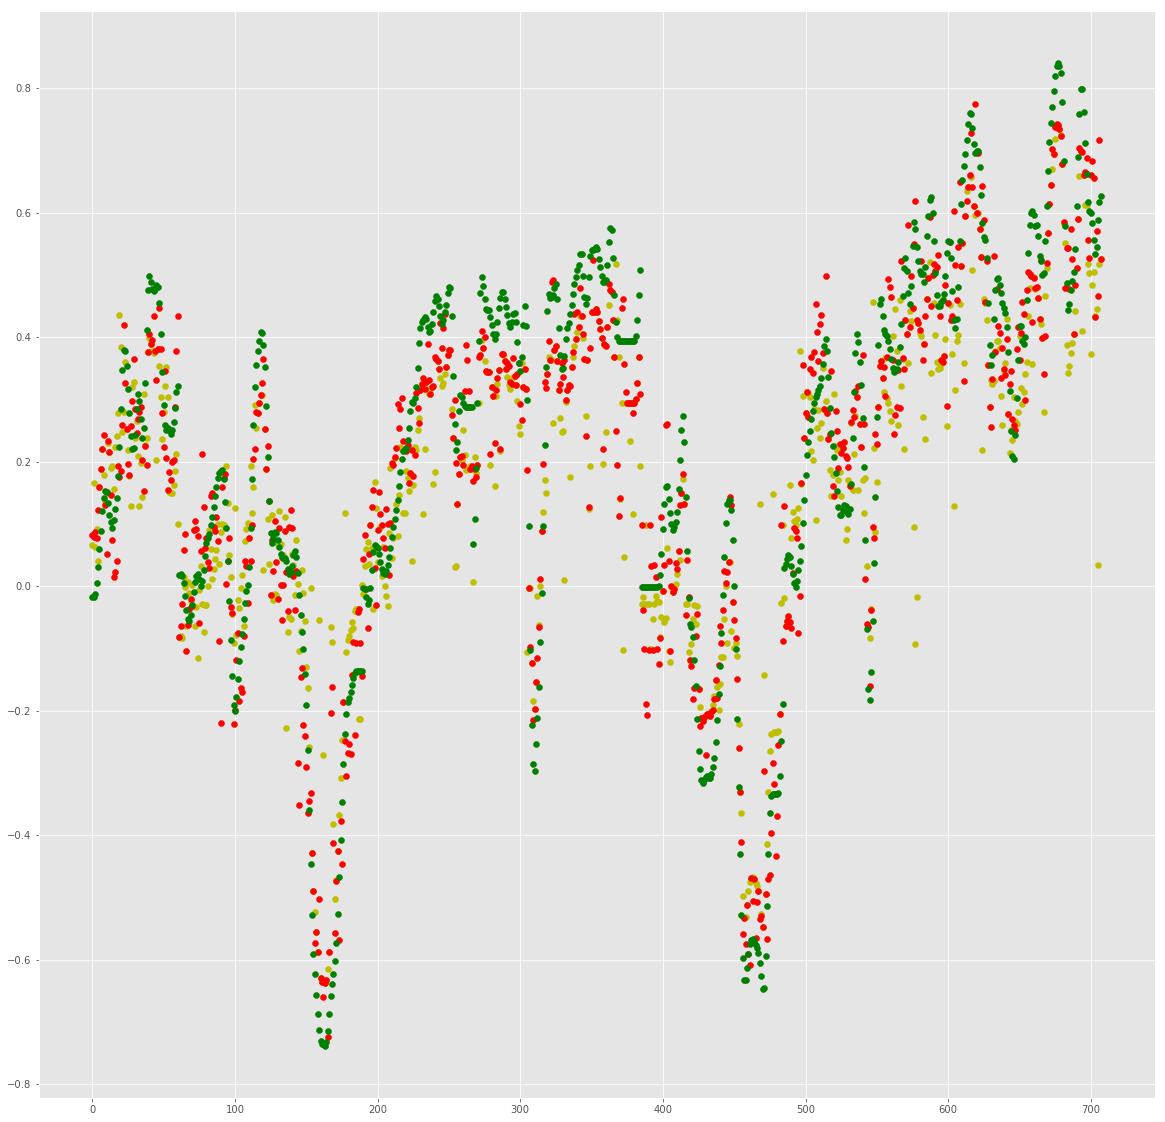

In [171]:
plt.figure(figsize=(20,20))
plt.scatter(range(len(testy)),y_pred_va_test,c='y')
plt.scatter(range(len(testy)),y_pred_vv_test,c='r')
plt.scatter(range(len(testy)),df2mat(testy[['MeanValence']]),c='g')


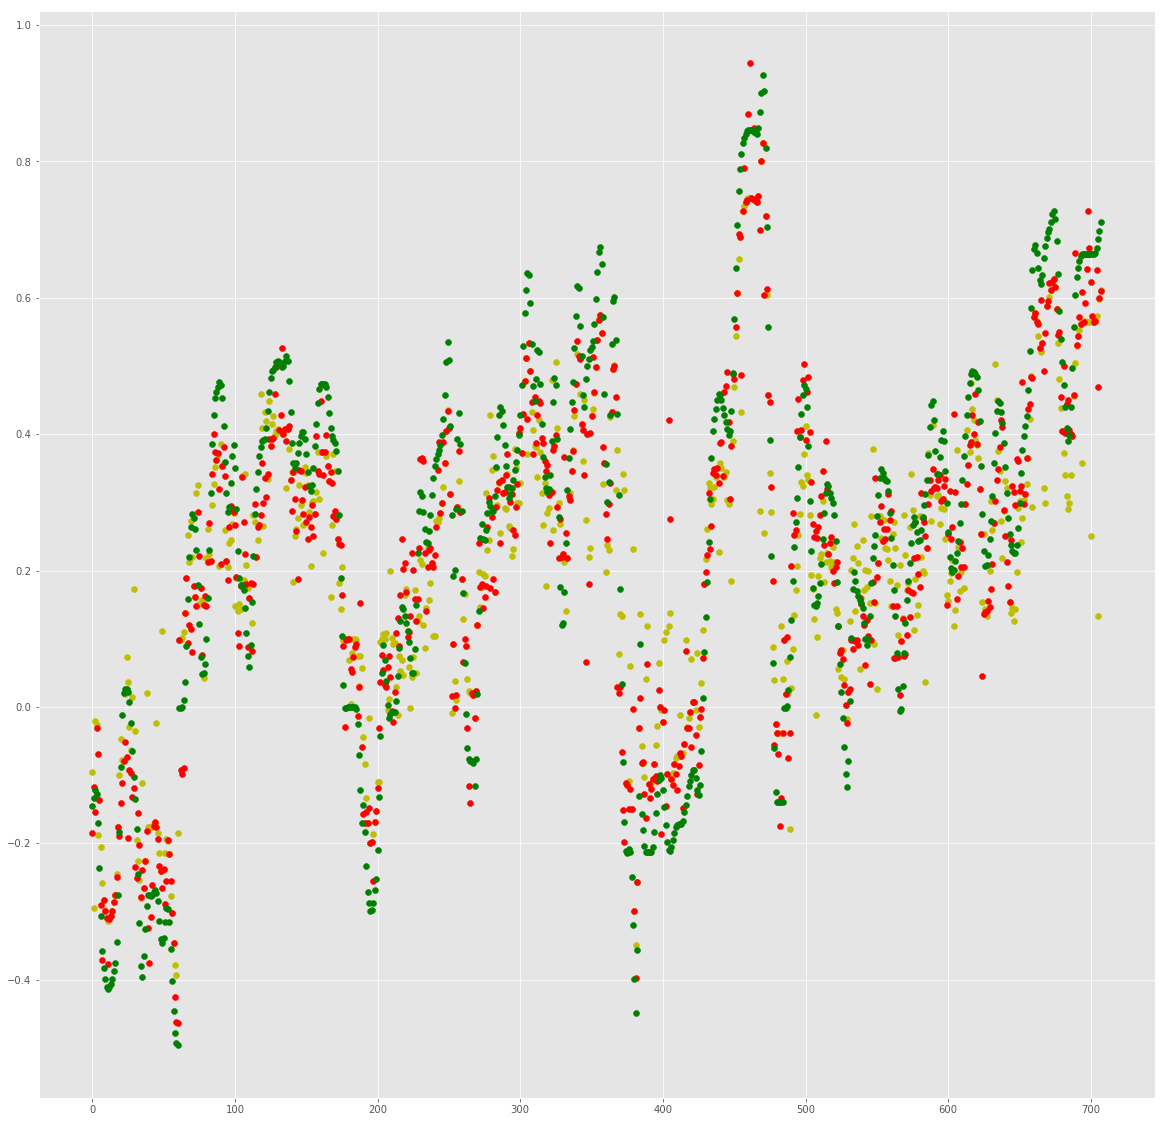

In [172]:
plt.figure(figsize=(20,20))
plt.scatter(range(len(testy)),y_pred_aa_test,c='y')
plt.scatter(range(len(testy)),y_pred_av_test,c='r')
plt.scatter(range(len(testy)),df2mat(testy[['MeanArousal']]),c='g')


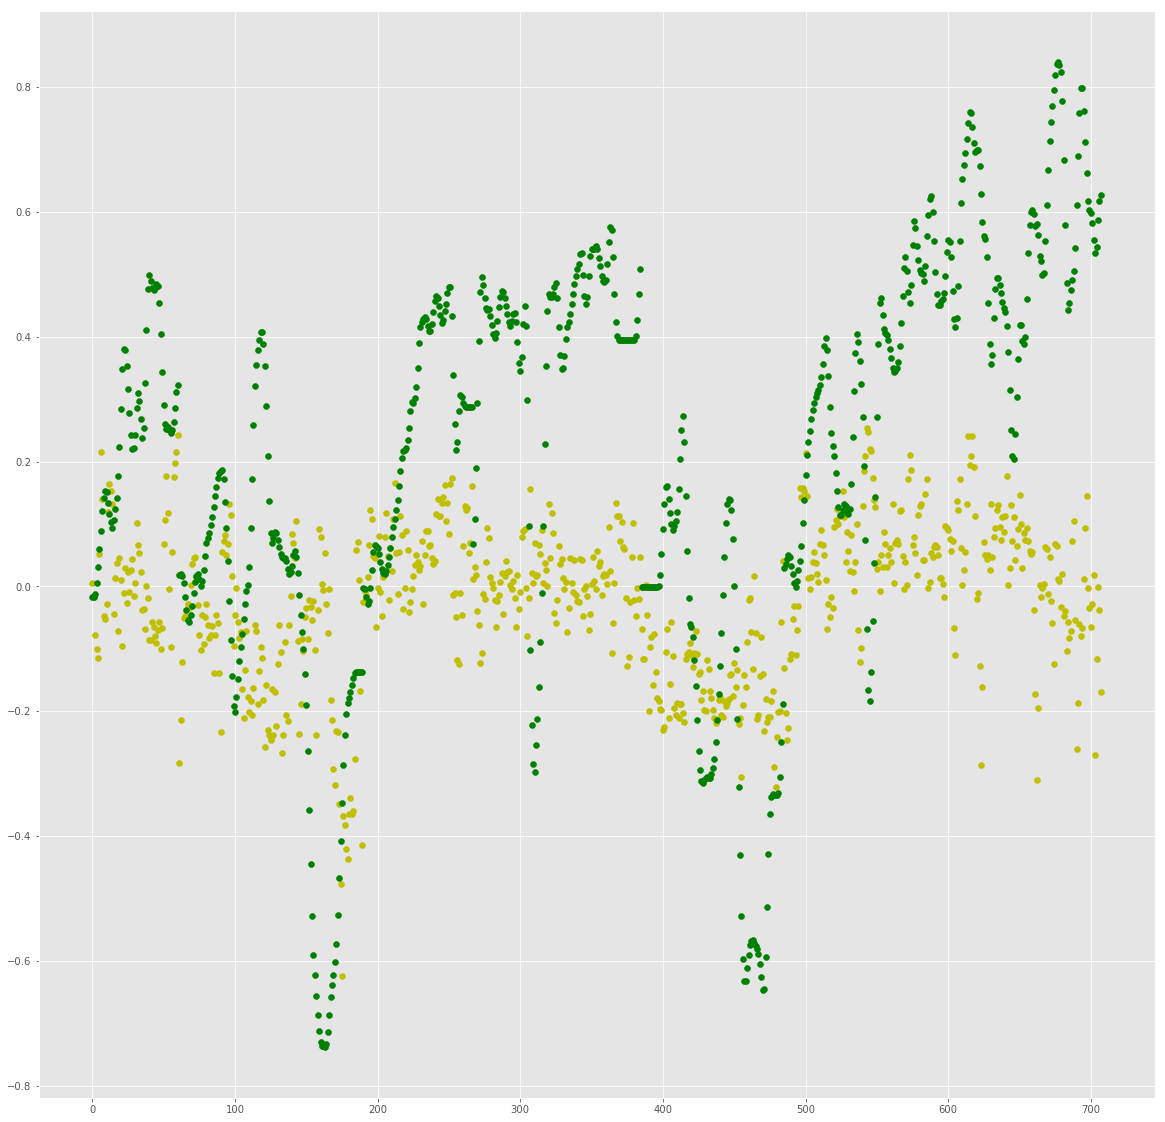

In [94]:
plt.figure(figsize=(20,20))
#plt.scatter(range(len(testy)),y_pred_meanV,c='y')
#plt.scatter(range(len(testy)),y_pred_visV_test,c='r')
#plt.scatter(range(len(testy)),y_pred_audV_test,c='b')
plt.scatter(range(len(testy)),df2mat(testy[['MeanValence']]),c='g')


In [95]:
y_pred_meanA = np.mean(np.transpose([y_pred_visA_test,y_pred_audA_test]),axis=1)

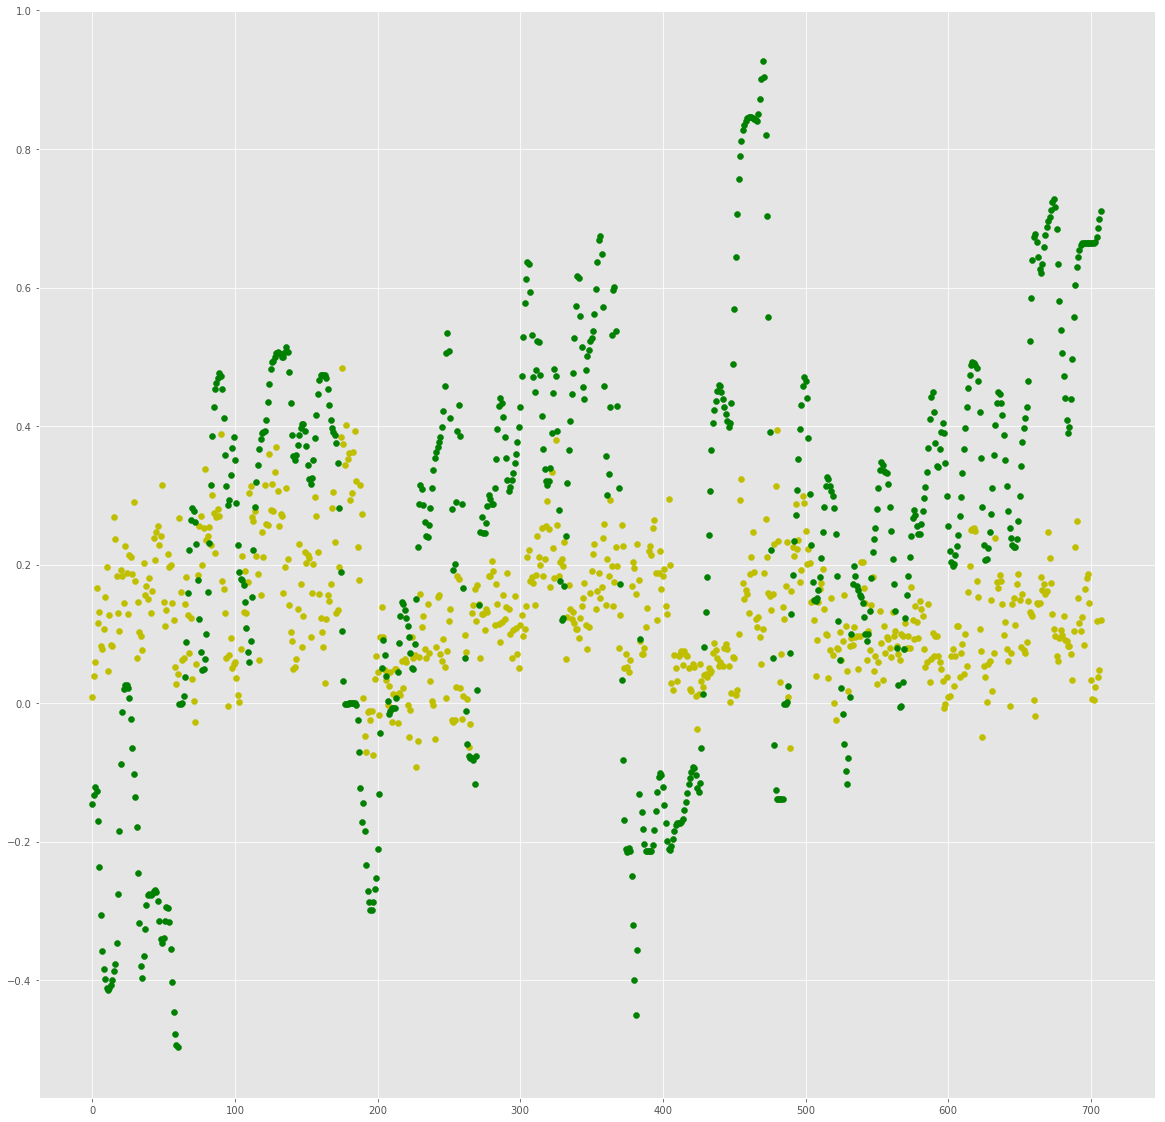

In [96]:
plt.figure(figsize=(20,20))
plt.scatter(range(len(testy)),y_pred_meanA,c='y')
#plt.scatter(range(len(testy)),y_pred_visA_test,c='r')
#plt.scatter(range(len(testy)),y_pred_audA_test,c='b')
plt.scatter(range(len(testy)),df2mat(testy[['MeanArousal']]),c='g')


# Test Run 1

In [190]:
print(pipe_audio_arousal, 
pipe_visual_arousal, 
pipe_audio_valence, 
pipe_visual_valence)


Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svr', SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.001,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False))]) Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svr', SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.001,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False))]) Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svr', SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.001,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False))]) Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svr', SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.001,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False))])


In [101]:
visual_feat_list= ['acc', 'cedd', 'cl', 'eh', 'fcth', 
               'gabor', 'jcd', 'lbp', 'sc', 'tamura'   ]

In [187]:
%%time
#pipe4aa
#pipe3av
#pipe2va
#pipe1vv
fname = 'me17ei_BOUNNKU_valence_arousal_1_run2.txt'
fd = open(fname, 'w')
fd.close()

test_set = {}
for f in testmovieNames:
    print(f)
    
    fd = open(fname, 'a')
    fd.write(f+'\n')  # python will convert \n to os.linesep
    fd.close()
    
    audiodf = getAudioDf(f,folder=med2017audiofolderTest)
    visualdf = getAvgVisFeatListDf(f,visual_feat_list,
                                   folder=med2017visualfolderTest)
    print(audiodf.shape,visualdf.shape)
    
    mlen = min(len(audiodf),len(visualdf))
    
    audiodf = audiodf[:mlen]
    visualdf = visualdf[:mlen]
    
    aa = pipe4aa.predict(audiodf)
    av = pipe3av.predict(visualdf)
    arousal_scores = np.transpose([ aa,av ])
    arousal_scores = np.mean(arousal_scores,axis=1)
    
    va = pipe2va.predict(audiodf)
    vv = pipe1vv.predict(visualdf)
    valence_scores = np.transpose([va,vv ])
    valence_scores = np.mean(valence_scores,axis=1)
    
    df =pd.DataFrame(np.transpose([valence_scores, arousal_scores]), columns=['MeanValence','MeanArousal'])
    df.to_csv(fname, sep=' ', index=False, header=False, mode='a')
    test_set[f] = df
    

MEDIAEVAL17_00
(702, 1583) (702, 1271)
MEDIAEVAL17_01
(167, 1583) (168, 1271)
MEDIAEVAL17_02
(943, 1583) (943, 1271)
MEDIAEVAL17_03
(1091, 1583) (1091, 1271)
MEDIAEVAL17_04
(151, 1583) (151, 1271)
MEDIAEVAL17_05
(1251, 1583) (1251, 1271)
MEDIAEVAL17_06
(1117, 1583) (1117, 1271)
MEDIAEVAL17_07
(41, 1583) (41, 1271)
MEDIAEVAL17_08
(40, 1583) (41, 1271)
MEDIAEVAL17_09
(41, 1583) (41, 1271)
MEDIAEVAL17_10
(41, 1583) (41, 1271)
MEDIAEVAL17_11
(41, 1583) (41, 1271)
MEDIAEVAL17_12
(41, 1583) (41, 1271)
MEDIAEVAL17_13
(41, 1583) (41, 1271)
CPU times: user 2min 50s, sys: 2.54 s, total: 2min 53s
Wall time: 2min 53s


In [184]:
# ploting results on dev-
dev_set = {}
for f in movieNames:
    audiodf = getAudioDf(f)
    visualdf = getAvgVisFeatListDf(f,visual_feat_list)
    print(audiodf.shape,visualdf.shape)
    
    mlen = min(len(audiodf),len(visualdf))
    
    audiodf = audiodf[:mlen]
    visualdf = visualdf[:mlen]
    
    aa = pipe4aa.predict(audiodf)
    av = pipe3av.predict(visualdf)
    arousal_scores = np.transpose([ aa,av ])
    arousal_scores = np.mean(arousal_scores,axis=1)
    
    va = pipe2va.predict(audiodf)
    vv = pipe1vv.predict(visualdf)
    valence_scores = np.transpose([va,vv ])
    valence_scores = np.mean(valence_scores,axis=1)
    
    df =pd.DataFrame(np.transpose([valence_scores, arousal_scores]), columns=['MeanValence','MeanArousal'])
    dev_set[f] = df


(116, 1583) (117, 1271)
(273, 1583) (273, 1271)
(196, 1583) (196, 1271)
(176, 1583) (176, 1271)
(118, 1583) (118, 1271)
(100, 1583) (101, 1271)
(139, 1583) (139, 1271)
(201, 1583) (202, 1271)
(912, 1583) (912, 1271)
(129, 1583) (129, 1271)
(127, 1583) (127, 1271)
(223, 1583) (223, 1271)
(33, 1583) (33, 1271)
(154, 1583) (154, 1271)
(77, 1583) (77, 1271)
(339, 1583) (339, 1271)
(61, 1583) (61, 1271)
(99, 1583) (99, 1271)
(157, 1583) (157, 1271)
(214, 1583) (214, 1271)
(179, 1583) (179, 1271)
(176, 1583) (176, 1271)
(184, 1583) (185, 1271)
(227, 1583) (227, 1271)
(145, 1583) (146, 1271)
(48, 1583) (49, 1271)
(185, 1583) (185, 1271)
(81, 1583) (82, 1271)
(22, 1583) (22, 1271)
(173, 1583) (173, 1271)


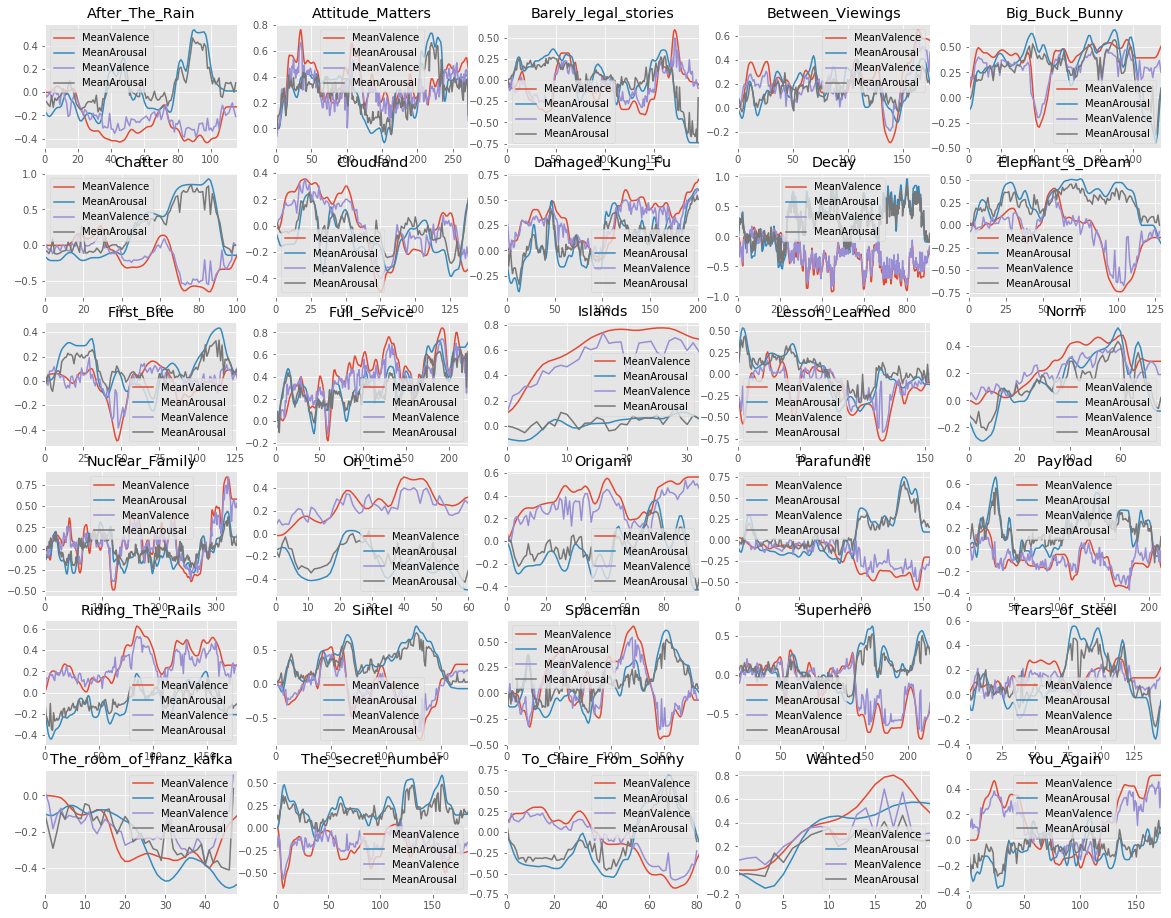

In [185]:
fix, axes = plt.subplots(figsize=(20,16))
for ii, mov in enumerate(movieNames):
    plt.subplot(6,5,ii+1)
    dfa = getAnnotationDf(mov)
    dfa[['MeanValence','MeanArousal']].plot(ax=plt.gca(),title=mov)
    dev_set[mov][['MeanValence','MeanArousal']].plot(ax=plt.gca(),title=mov)



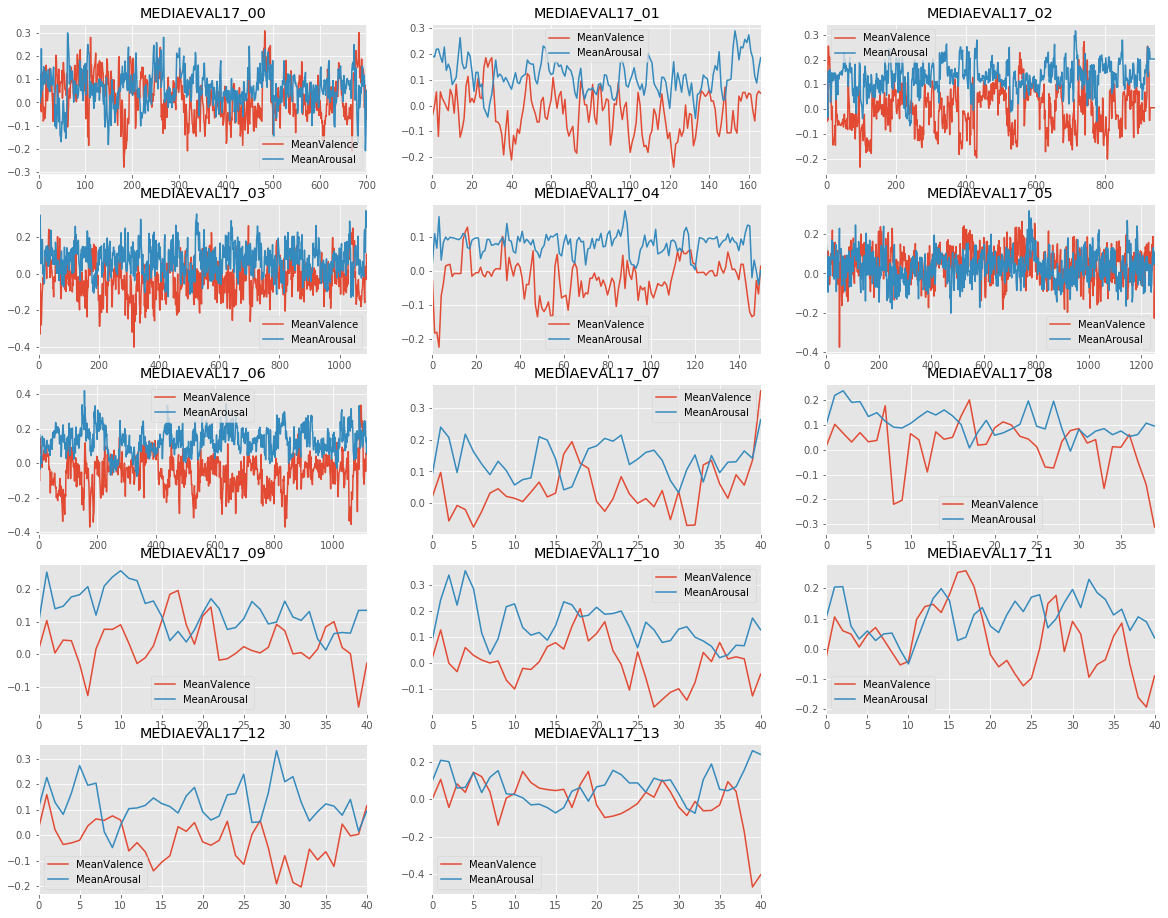

In [188]:
fix, axes = plt.subplots(figsize=(20,16))
for ii, mov in enumerate(testmovieNames):
    plt.subplot(5,3,ii+1)
    test_set[mov][['MeanValence','MeanArousal']].plot(ax=plt.gca(),title=mov)



## this run have some bug related to pipes 

In [138]:
%%time
fname = 'me17ei_BOUNNKU_valence_arousal_1.txt'
fd = open(fname, 'w')
fd.close()

for f in testmovieNames:
    print(f)
    
    fd = open(fname, 'a')
    fd.write(f+'\n')  # python will convert \n to os.linesep
    fd.close()
    
    audiodf = getAudioDf(f,folder=med2017audiofolderTest)
    visualdf = getAvgVisFeatListDf(f,visual_feat_list,
                                   folder=med2017visualfolderTest)
    print(audiodf.shape,visualdf.shape)
    
    mlen = min(len(audiodf),len(visualdf))
    
    audiodf = audiodf[:mlen]
    visualdf = visualdf[:mlen]
    
    aa = pipe_audio_arousal.predict(audiodf)
    av = pipe_visual_arousal.predict(visualdf)
    arousal_scores = np.transpose([ aa,av ])
    arousal_scores = np.mean(arousal_scores,axis=1)
    
    va = pipe_audio_valence.predict(audiodf)
    vv = pipe_visual_valence.predict(visualdf)
    valence_scores = np.transpose([va,vv ])
    valence_scores = np.mean(valence_scores,axis=1)
    
    df =pd.DataFrame(np.transpose([valence_scores, arousal_scores]), columns=['MeanValence','MeanArousal'])
    df.to_csv(fname, sep=' ', index=False, header=False, mode='a')
    

MEDIAEVAL17_00
(702, 1583) (702, 1271)
MEDIAEVAL17_01
(167, 1583) (168, 1271)
MEDIAEVAL17_02
(943, 1583) (943, 1271)
MEDIAEVAL17_03
(1091, 1583) (1091, 1271)
MEDIAEVAL17_04
(151, 1583) (151, 1271)
MEDIAEVAL17_05
(1251, 1583) (1251, 1271)
MEDIAEVAL17_06
(1117, 1583) (1117, 1271)
MEDIAEVAL17_07
(41, 1583) (41, 1271)
MEDIAEVAL17_08
(40, 1583) (41, 1271)
MEDIAEVAL17_09
(41, 1583) (41, 1271)
MEDIAEVAL17_10
(41, 1583) (41, 1271)
MEDIAEVAL17_11
(41, 1583) (41, 1271)
MEDIAEVAL17_12
(41, 1583) (41, 1271)
MEDIAEVAL17_13
(41, 1583) (41, 1271)
CPU times: user 2min 53s, sys: 2.18 s, total: 2min 55s
Wall time: 2min 55s


In [116]:
df =pd.DataFrame(np.transpose([valence_scores, arousal_scores]), columns=['MeanValence','MeanArousal'])

In [125]:
df.to_csv('M00.txt', sep=' ', index=False, header=False, mode='a')

In [142]:
!ls m*

me17ei_BOUNNKU_valence_arousal_1.txt

models:
fear-audio-svm.pkl  fear-fusion-logisticreg.pkl  fear-visual-svm.pkl
